In [ ]:
#!pip install accelerate -U

In [ ]:
import transformers
import torch, torchtext
import torch.nn.functional as F
import torch.nn as nn
import copy

from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel, AutoModel, AutoProcessor
from tqdm import tqdm

import os
import math
import gc
import datetime

import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

from torchvision import transforms
from torchvision.utils import make_grid
import torch.optim as optim
import itertools
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

batch_size = 4
num_epochs = 25
image_size = 224

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

MODEL_NUM_LABELS = 2
EMBEDDING_DIM = 768
TEXT_MODEL_CARD = 'bert-base-uncased'

LABEL_2_ID = {
    'normal': 0,
    'Lung': 1
}

ID_2_LABEL = {
    0: 'normal',
    1: 'Lung'
}

num_processors = os.cpu_count()

cpu
Using device: cpu


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
path = "/content/drive/MyDrive/DataForDiplom/LungsImgDatasetInd/images_normalized"
dir_list = os.listdir(path)

In [ ]:
df2 = pd.read_csv('/content/drive/MyDrive/DataForDiplom/LungsImgDatasetInd/indiana_projections.csv')
df1 = pd.read_csv('/content/drive/MyDrive/DataForDiplom/LungsImgDatasetInd/indiana_reports.csv')
df2 = df2.loc[df2['projection'].isin(['Frontal'])]
df2 = df2.loc[df2['filename'].isin(dir_list)]
df1.loc[df1['Problems'].str.contains('Lung'),'Problems']='Lung'
df1_l = df1.loc[df1['Problems'].isin(['Lung'])]

df1_n = df1.loc[df1['Problems'].isin(['normal'])]
print(len(df1_l), len(df1_n))
df1_n = df1_n.iloc[:len(df1_l)-len(df1_n)]
df1 = pd.concat([df1_l, df1_n], axis=0).sample(frac=1).reset_index(drop=True)
df1 = df1[:]
print(len(df1))


images_captions_df = pd.DataFrame({'image': [],
                                    'caption': [],'number_of_words':[],'problem':[]})
for i in range(len(df2)):
    uid = df2.iloc[i]['uid']
    image = df2.iloc[i]['filename']
    index = df1.loc[df1['uid'] ==uid]

    if not index.empty:
        index = index.index[0]
        caption = df1.loc[index]['findings']
        problem = df1.loc[index]['Problems']
        number_of_words = len(str(caption).split())

        if type(caption) == float:
                continue
        images_captions_df = pd.concat([images_captions_df, pd.DataFrame([{'image': image, 'caption': caption ,'number_of_words':number_of_words,'problem':problem}])], ignore_index=True)

images_captions_df["number_of_words"] =  images_captions_df["caption"].apply(lambda text: len(str(text).split()))
images_captions_df['number_of_words'] = images_captions_df['number_of_words'].astype(int)

print(images_captions_df.head())


from sklearn.model_selection import train_test_split

image_folder = '/content/drive/MyDrive/DataForDiplom/LungsImgDatasetInd/images_normalized'
image_filenames = images_captions_df.image.values

train_captions,test_val_captions =train_test_split(images_captions_df, test_size = 0.2)
test_captions, val_captions =train_test_split(test_val_captions, test_size = 0.4)

print(train_captions.head())
print(len(train_captions),len(test_captions),len(val_captions))

558 1379
1116
                       image  \
0     1_IM-0001-4001.dcm.png   
1  5_IM-2117-1003002.dcm.png   
2    11_IM-0067-1001.dcm.png   
3    12_IM-0133-1001.dcm.png   
4    14_IM-0256-1001.dcm.png   

                                             caption  number_of_words problem  
0  The cardiac silhouette and mediastinum size ar...               34  normal  
1  The cardiomediastinal silhouette and pulmonary...               42    Lung  
2  Cardiomediastinal silhouette and pulmonary vas...               21  normal  
3  Lungs are clear bilaterally. Cardiac and media...               23  normal  
4  Heart size within normal limits, stable medias...               37    Lung  
                         image  \
828  2802_IM-1234-1001.dcm.png   
629  1477_IM-0309-1001.dcm.png   
451  1078_IM-0055-1001.dcm.png   
356   855_IM-2376-1001.dcm.png   
295   721_IM-2282-1001.dcm.png   

                                               caption  number_of_words  \
828  Hyperexpanded lungs. Lungs a

In [ ]:
def image_preprocessing(image_path,target_size):
    img = cv2.imread(image_path)
    img = cv2.resize(img,(target_size,target_size), )
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def display_image(image_array):
    plt.imshow(image_array)
    plt.axis('off')
    plt.show()

'''image = image_preprocessing("/content/drive/MyDrive/LungsImgDatasetInd/images_normalized/1003_IM-0005-2002.dcm.png",image_size)
print(image.shape)
display_image(image)'''

'image = image_preprocessing("/content/drive/MyDrive/LungsImgDatasetInd/images_normalized/1003_IM-0005-2002.dcm.png",image_size)\nprint(image.shape)\ndisplay_image(image)'

In [ ]:
# Example dataset class
class ImageTextDataset(Dataset):
    def __init__(self, image_filenames, captions, problems, image_size=256):
        self.image_filenames = image_filenames
        self.captions = captions
        self.problems = problems
        self.transform = transforms.Compose([
                                                 # Resize images to a consistent size
                                                #transforms.ToTensor(),
                                                transforms.ToTensor(),          # Convert images to tensors
                                                # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize images
                                            ])
    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, index):
        image_path = "/content/drive/MyDrive/DataForDiplom/LungsImgDatasetInd/images_normalized/"+image_filenames[index]

        image = image_preprocessing(image_path,image_size ) #
        image = list(np.array(self.transform(image)))#.permute(2,1,0)
        text = self.captions[index]
        problem = LABEL_2_ID[self.problems[index]]

        return image, text, problem

# Create an instance of the dataset

train_dataset = ImageTextDataset(train_captions.image.values, train_captions.caption.values, train_captions.problem.values, image_size)
test_dataset = ImageTextDataset(test_captions.image.values, test_captions.caption.values, test_captions.problem.values, image_size)
val_dataset = ImageTextDataset(val_captions.image.values, val_captions.caption.values, val_captions.problem.values, image_size)
print('train_dataset: ',len(train_dataset),'test_dataset: ',len(test_dataset),'val_dataset: ',len(val_dataset))

train_dataset:  777 test_dataset:  117 val_dataset:  78


In [ ]:
val_captions.problem.values

array(['Lung', 'Lung', 'Lung', 'normal', 'Lung', 'Lung', 'normal', 'Lung',
       'Lung', 'Lung', 'normal', 'Lung', 'normal', 'normal', 'normal',
       'Lung', 'normal', 'Lung', 'Lung', 'Lung', 'normal', 'normal',
       'normal', 'Lung', 'normal', 'Lung', 'normal', 'normal', 'normal',
       'normal', 'Lung', 'normal', 'normal', 'Lung', 'Lung', 'Lung',
       'Lung', 'Lung', 'normal', 'Lung', 'normal', 'Lung', 'Lung',
       'normal', 'Lung', 'Lung', 'normal', 'normal', 'normal', 'normal',
       'Lung', 'Lung', 'normal', 'normal', 'Lung', 'normal', 'Lung',
       'normal', 'Lung', 'normal', 'normal', 'Lung', 'Lung', 'Lung',
       'Lung', 'normal', 'Lung', 'normal', 'Lung', 'Lung', 'Lung', 'Lung',
       'normal', 'normal', 'Lung', 'normal', 'normal', 'normal'],
      dtype=object)

# Create a DataLoader

In [ ]:
def create_dataloader(dataset, batch_size):
    """
    Create a DataLoader object from the given dataset with the given batch size
    Args:
        dataset: dataset to use
        batch_size: batch size to use
    """
    def pack_fn(batch):
        """
        Function to pad the audio features and create the attention mask
        """
        texts = [x[1] for x in batch]
        ''''for x in batch:
            print(type(x[0]),x[0].shape)
            print('x[0]\r\n',x[0])'''
        img_features = [x[0] for x in batch]
        img_features = np.array(img_features)
        audio_features= torch.from_numpy(img_features)
        labels = torch.tensor([x[2] for x in batch])
        return texts, audio_features, labels

    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=pack_fn)
    return dataloader

In [ ]:
train_dataloader = create_dataloader(train_dataset, batch_size)
val_dataloader = create_dataloader(val_dataset, batch_size)
test_dataloader = create_dataloader(test_dataset, batch_size)

In [ ]:
def create_models(
        head_hidden_dimension=224, dropout_prob=0.1, hidden_state_index=8,   # shared parameters head_hidden_dimension=256
        audioonly_nheads=8, audioonly_d_ffn=100, audioonly_n_layers=1, # audio only parameters
        csa_nheads=4, csa_d_ffn=2048, csa_n_layers=1, # multimodal parameters
        ensembling_nheads=4, ensembling_d_ffn=2048, ensembling_n_layers=1, # ensembling parameters
        multa_nblocks=4, multa_d_ffn=2048 # unaligned parameters
    ):
    text_only_head = nn.Sequential(
        nn.Linear(EMBEDDING_DIM, head_hidden_dimension),
        nn.ReLU(),
        nn.Linear(head_hidden_dimension, MODEL_NUM_LABELS)
    ).to(device)
    text_only = TextModel(tokenizer, embedder, text_only_head)
    model_names = ['Text-Only']
    models = [text_only]
    return model_names, models

In [ ]:
# set up tokenizer and model
tokenizer = BertTokenizer.from_pretrained(TEXT_MODEL_CARD)
embedder = BertModel.from_pretrained(TEXT_MODEL_CARD).to(device)

# freeze bert layers
for params in embedder.parameters():
    params.requires_grad = False

num_claim = len(df1.loc[df1['Problems'].isin(['normal'])])
print(f'Total Normal: {num_claim}: {num_claim*100/len(df1):.2f}%')

num_premise = len(df1.loc[df1['Problems'].isin(['Lung'])])
print(f'Total Lung: {num_premise}: {num_premise*100/len(df1):.2f}%')

if MODEL_NUM_LABELS == 2:
    claim_ratio = num_claim / (num_claim + num_premise)
    premise_ratio = num_premise / (num_claim + num_premise)
    weight = torch.tensor([1/(2*claim_ratio), 1/(2*premise_ratio)]).to(device)
else:
    claim_ratio = num_claim / (num_claim + num_premise + num_other)
    premise_ratio = num_premise / (num_claim + num_premise + num_other)
    other_ratio = num_other / (num_claim + num_premise + num_other)
    weight = torch.tensor([1/(3*claim_ratio), 1/(3*premise_ratio), 1/(3*other_ratio)]).to(device)

print(f'Weight for loss function: {weight}')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Total Normal: 558: 50.00%
Total Lung: 558: 50.00%
Weight for loss function: tensor([1., 1.])


In [ ]:
class BestModel:
    """
    Class to keep track of the best performing model on validation set during training
    """
    def __init__(self):
        self.best_validation_loss = float('Infinity')
        self.best_state_dict = None
    def __call__(self, model, loss):
        if loss < self.best_validation_loss:
            self.best_validation_loss = loss
            self.best_state_dict = copy.deepcopy(model.state_dict())

def evaluate(model, data_loader, loss_fn, debug=False):
    """
    Evaluate the model on the set passed
    Args:
        model: model to evaluate
        data_loader: DataLoader object
        loss_fn: loss function to use
        debug: whether to print debug statements
    """
    model.eval()
    total_loss = 0.0
    num_correct = 0
    num_examples = 0
    tot_pred, tot_targ, tot_logits = torch.LongTensor(), torch.LongTensor(), torch.LongTensor()
    for batch in data_loader:
        texts, img_features, targets = batch
        output = model(texts,img_features)
        loss = loss_fn(output, targets)
        total_loss += loss.detach()

        scores = output[:, :2]
        predicted_labels = torch.argmax(scores, dim=-1)

        tot_pred = torch.cat((tot_pred, predicted_labels.detach().cpu()))
        tot_targ = torch.cat((tot_targ, targets.detach().cpu()))
        tot_logits = torch.cat((tot_logits, torch.nn.functional.softmax(scores, dim=-1)[:, 1].detach().cpu()))

        correct = torch.eq(predicted_labels, targets).view(-1)
        num_correct += torch.sum(correct).item()
        num_examples += correct.shape[0]
    total_loss = total_loss.cpu().item()
    total_loss /= len(data_loader.dataset)
    accuracy = num_correct/num_examples
    return total_loss, accuracy, tot_pred, tot_targ, tot_logits


def train(model, loss_fn, train_loader, val_loader, epochs=10, device="cuda", lr=1e-3, lr_decay_factor=0.1, lr_decay_patience=3, weight_decay=1e-5, verbose=True, debug=False):
    """
    Train the model on the train set and evaluate on the validation set with the given parameters
    Args:
        model: model to train
        loss_fn: loss function to use
        train_loader: DataLoader object for train set
        val_loader: DataLoader object for validation set
        epochs: number of epochs
        device: device to use
        lr: initial learning rate
        lr_decay_factor: factor to decay learning rate
        lr_decay_patience: patience for learning rate decay
        weight_decay: weight decay
        verbose: whether to print training results
        debug: whether to print debug statements
    """
    # set up optimizer and scheduler
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=lr_decay_factor, patience=lr_decay_patience, verbose=True)
    best_model_tracker = BestModel()
    # history of train and validation losses, accuracy
    history_train_losses = []
    history_train_accuracy = []

    history_val_losses = []
    history_val_accuracy = []

    for epoch in tqdm(range(epochs)):
        # training
        correct = 0
        training_loss = 0.0
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            texts, img_features, targets = batch
            output = model(texts,img_features)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            correct += torch.eq(torch.argmax(output, dim=-1), targets).view(-1).sum()
            training_loss += loss.detach()
        training_loss = training_loss.cpu().item()

        training_loss /= len(train_loader.dataset)
        training_accuracy = correct.item() / len(train_loader.dataset)

        valid_loss, valid_accuracy, val_pred, val_targ, _ = evaluate(model, val_loader, loss_fn, debug)
        print(val_pred, val_targ)

        history_train_losses.append(training_loss)
        history_train_accuracy.append(training_accuracy)

        history_val_losses.append(valid_loss)
        history_val_accuracy.append(valid_accuracy)

        print(valid_loss, best_model_tracker.best_validation_loss)
        if valid_loss < best_model_tracker.best_validation_loss:
          print('save model')
          #torch.save(model, '/content/drive/MyDrive/models/'+'text_model_'+datetime.datetime.now().strftime("%Y_%m_%d_%H_%M"))

        best_model_tracker(model, valid_loss)
        scheduler.step(valid_loss)

        if verbose:
            print(f'Epoch: {epoch}, Training Loss: {training_loss:.4f}, Validation Loss: {valid_loss:.4f}, accuracy = {valid_accuracy:.4f}')
    # restore best model weights
    model.load_state_dict(best_model_tracker.best_state_dict)

    history = {
        'train_loss': history_train_losses,
        'train_accuracy': history_train_accuracy,
        'train_f1': history_train_f1,
        'val_loss': history_val_losses,
        'val_accuracy': history_val_accuracy
    }
    return model, history

In [ ]:
class TextModel(nn.Module):
    """
    Class for the text-only model
    """
    def __init__(self, tokenizer, embedder, head):
        """
        Args:
            tokenizer: tokenizer to use
            embedder: embedder to use
            head: head to use
        """
        super().__init__()
        self.tokenizer = tokenizer
        self.embedder = embedder
        self.head = head
    def forward(self, texts, audio_features):
        """, audio_attention
        Forward pass of the model
        Args:
            texts: texts to use
            audio_features: audio features to use
            audio_attentions: audio attentions to use
        """
        """
        вернуть  torch.Tensor return_tensors='pt'
        padding=True - Дополнить до самой длинной последовательности в пакете
        """
        tokenizer_output = self.tokenizer(texts, return_tensors='pt', padding=True, truncation=False).to(device)
        embedder_output = self.embedder(**tokenizer_output, output_hidden_states=True)
        text_features = embedder_output['last_hidden_state']
        text_features_sum = (text_features * tokenizer_output.attention_mask.unsqueeze(-1)).sum(axis=1) #torch.Size([4, 768])
        text_features_pooled = text_features_sum / tokenizer_output.attention_mask.sum(axis=1).unsqueeze(-1) #torch.Size([4, 768])
        return self.head(text_features_pooled)

In [ ]:
#SEEDS = [1, 42, 69, 100, 420]
SEEDS = [1]
from transformers import TrainingArguments
dict_model_names = ['Text-Only']

# initialize results
val_results = {n : [] for n in dict_model_names}
test_results = {n : [] for n in dict_model_names}

# initialize history
history_train_losses = {n : [] for n in dict_model_names}
history_train_accuracy = {n : [] for n in dict_model_names}
history_train_f1 = {n : [] for n in dict_model_names}
history_val_losses = {n : [] for n in dict_model_names}
history_val_accuracy = {n : [] for n in dict_model_names}
history_val_f1 = {n : [] for n in dict_model_names}

EPOCHS = 5
INITIAL_LR = 5e-5
WEIGHT_DECAY = 0.01
LR_DECAY_FACTOR = 0.9
LR_DECAY_PATIENCE = 15
VERBOSE_TRAIN = True
DEBUG_TRAIN = False

for seed in SEEDS:
    print(f'{f"TRAINING WITH SEED {seed}":=^100}')
    print()
    torch.manual_seed(seed)
    np.random.seed(seed)
    model_names, models = create_models()
    while models:
        model = models[0]
        model_name = model_names[0]

        torch.manual_seed(seed)
        np.random.seed(seed)

        print(f'{f"Training model {model_name}":_^100}')

        loss = nn.CrossEntropyLoss(weight=weight)

        _, history = train(
              model,
              loss,
              epochs=EPOCHS,
              train_loader=train_dataloader,
              val_loader=val_dataloader,
              device=device,
              weight_decay=WEIGHT_DECAY,
              lr=INITIAL_LR,
              )
        history_train_losses[model_name].append(history['train_loss'])
        history_train_accuracy[model_name].append(history['train_accuracy'])
        history_val_losses[model_name].append(history['val_loss'])
        history_val_accuracy[model_name].append(history['val_accuracy'])

        _, val_acc, val_pred, val_targ, val_logits = evaluate(model, val_dataloader, loss)
        print(val_pred, val_targ)
        val_results[model_name].append({'acc': val_acc, 'pred': val_pred, 'targ': val_targ, 'logits':val_logits})

        _, test_acc, test_pred, test_targ, test_logits = evaluate(model, test_dataloader, loss)
        test_results[model_name].append({'acc': test_acc, 'pred': test_pred, 'targ': test_targ, 'logits':test_logits})
        print(test_pred, test_targ)
        if VERBOSE_TRAIN:
            print(f'[VAL] Model: {model_name} - acc: {val_acc:.4f}')
            print(f'[TEST] Model: {model_name} - acc: {test_acc:.4f}')
            print()

        # delete model to free up memory and avoid memory errors
        del model
        del models[0]
        del model_names[0]
        gc.collect()

========================================TRAINING WITH SEED 1========================================

______________________________________Training model Text-Only______________________________________


  0%|          | 0/5 [00:00<?, ?it/s]

tensor([0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0,
        0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1,
        0, 0, 0, 0, 0, 1]) tensor([0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0,
        0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0,
        0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
        0, 0, 0, 0, 0, 1])
0.1581268432812813 inf
save model


 20%|██        | 1/5 [21:19<1:25:17, 1279.35s/it]

Epoch: 0, Training Loss: 0.1655, Validation Loss: 0.1581, accuracy = 0.7821
tensor([0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1,
        1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0,
        0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1,
        1, 0, 0, 1, 1, 1]) tensor([1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1,
        1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0,
        0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0,
        1, 0, 0, 0, 1, 1])
0.1351324228140024 0.1581268432812813
save model


 40%|████      | 2/5 [26:00<34:36, 692.08s/it]   

Epoch: 1, Training Loss: 0.1450, Validation Loss: 0.1351, accuracy = 0.8333


 60%|██████    | 3/5 [30:38<16:45, 502.99s/it]

tensor([1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0,
        0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0,
        0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1,
        1, 1, 0, 1, 0, 0]) tensor([1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0,
        0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1,
        1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1,
        1, 1, 0, 1, 0, 0])
0.12329292297363281 0.1351324228140024
save model
Epoch: 2, Training Loss: 0.1258, Validation Loss: 0.1233, accuracy = 0.8205


 80%|████████  | 4/5 [35:15<06:53, 413.82s/it]

tensor([0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0,
        0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0,
        0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0,
        1, 1, 1, 0, 0, 0]) tensor([0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0,
        1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0,
        0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0,
        1, 1, 1, 0, 1, 0])
0.112945128709842 0.12329292297363281
save model
Epoch: 3, Training Loss: 0.1131, Validation Loss: 0.1129, accuracy = 0.8333


100%|██████████| 5/5 [39:56<00:00, 479.28s/it]

tensor([0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1,
        0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
        1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1,
        1, 0, 1, 1, 0, 0]) tensor([0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1,
        0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
        1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1,
        1, 0, 1, 1, 0, 0])
0.0971830441401555 0.112945128709842
save model
Epoch: 4, Training Loss: 0.1018, Validation Loss: 0.0972, accuracy = 0.9359


tensor([1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1,
        1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0,
        1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        0, 1, 1, 0, 0, 1]) tensor([1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1,
        0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0,
        1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        0, 1, 1, 0, 0, 1])
tensor([0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1,
        0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1,
        1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1,
        0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0]) tensor([0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 

In [ ]:
import time

# начальное время
start_time = time.time()

#SEEDS = [1, 42, 69, 100, 420]
SEEDS = [1]
from transformers import TrainingArguments
dict_model_names = ['Text-Only']

# initialize results
val_results = {n : [] for n in dict_model_names}
test_results = {n : [] for n in dict_model_names}

# initialize history
history_train_losses = {n : [] for n in dict_model_names}
history_train_accuracy = {n : [] for n in dict_model_names}
history_train_f1 = {n : [] for n in dict_model_names}
history_val_losses = {n : [] for n in dict_model_names}
history_val_accuracy = {n : [] for n in dict_model_names}
history_val_f1 = {n : [] for n in dict_model_names}

EPOCHS = 5
INITIAL_LR = 5e-5
WEIGHT_DECAY = 0.01
LR_DECAY_FACTOR = 0.9
LR_DECAY_PATIENCE = 15
VERBOSE_TRAIN = True
DEBUG_TRAIN = False

for seed in SEEDS:
    print(f'{f"TRAINING WITH SEED {seed}":=^100}')
    print()
    torch.manual_seed(seed)
    np.random.seed(seed)
    model_names, models = create_models()
    while models:
        model = models[0]
        model_name = model_names[0]

        torch.manual_seed(seed)
        np.random.seed(seed)

        print(f'{f"Training model {model_name}":_^100}')

        loss = nn.CrossEntropyLoss(weight=weight)

        _, history = train(
              model,
              loss,
              epochs=1,
              train_loader=train_dataloader,
              val_loader=val_dataloader,
              device=device,
              weight_decay=WEIGHT_DECAY,
              lr=INITIAL_LR,
              )
        history_train_losses[model_name].append(history['train_loss'])
        history_train_accuracy[model_name].append(history['train_accuracy'])
        history_val_losses[model_name].append(history['val_loss'])
        history_val_accuracy[model_name].append(history['val_accuracy'])

        _, val_acc, val_pred, val_targ, val_logits = evaluate(model, val_dataloader, loss)
        print(val_pred, val_targ)
        val_results[model_name].append({'acc': val_acc, 'pred': val_pred, 'targ': val_targ, 'logits':val_logits})

        _, test_acc, test_pred, test_targ, test_logits = evaluate(model, test_dataloader, loss)
        test_results[model_name].append({'acc': test_acc, 'pred': test_pred, 'targ': test_targ, 'logits':test_logits})
        print(test_pred, test_targ)
        if VERBOSE_TRAIN:
            print(f'[VAL] Model: {model_name} - acc: {val_acc:.4f}')
            print(f'[TEST] Model: {model_name} - acc: {test_acc:.4f}')
            print()

        # delete model to free up memory and avoid memory errors
        del model
        del models[0]
        del model_names[0]
        gc.collect()
# конечное время
end_time = time.time()

# разница между конечным и начальным временем
elapsed_time = end_time - start_time
print('Elapsed time: ', elapsed_time)

========================================TRAINING WITH SEED 1========================================

______________________________________Training model Text-Only______________________________________


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
        0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0,
        0, 0, 1, 1, 1, 0]) tensor([1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1,
        0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
        0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1,
        0, 1, 1, 1, 0, 0])
0.1597586533962152 inf
save model


100%|██████████| 1/1 [05:44<00:00, 344.07s/it]

Epoch: 0, Training Loss: 0.1667, Validation Loss: 0.1598, accuracy = 0.7436


tensor([0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0,
        0, 1, 1, 1, 1, 0]) tensor([0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0,
        0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,
        1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 0])
tensor([0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0,
        1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0,
        0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0,
        1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0]) tensor([1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 

In [ ]:
history_train_losses = []
history_train_accuracy = []
history_train_f1 = []
history_val_losses = []
history_val_accuracy = []
history_val_f1 = []

history_train_losses.append(history['train_loss'])
history_train_accuracy.append(history['train_accuracy'])
history_val_losses.append(history['val_loss'])
history_val_accuracy.append(history['val_accuracy'])

_, val_acc, val_pred, val_targ, val_logits = evaluate(model, val_dataloader, loss)
print(val_pred, val_targ)

_, test_acc, test_pred, test_targ, test_logits = evaluate(model, test_dataloader, loss)
print(test_pred, test_targ)
if VERBOSE_TRAIN:
    print(f'[VAL] Model: {model_name} - acc: {val_acc:.4f}')
    print(f'[TEST] Model: {model_name} - acc: {test_acc:.4f}')
    print()

tensor([0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1,
        0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0,
        1, 0, 0, 1, 1, 1]) tensor([0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1,
        0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0,
        1, 0, 0, 1, 1, 0])
tensor([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0,
        0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0,
        0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0,
        1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1,
        0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]) tensor([0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 

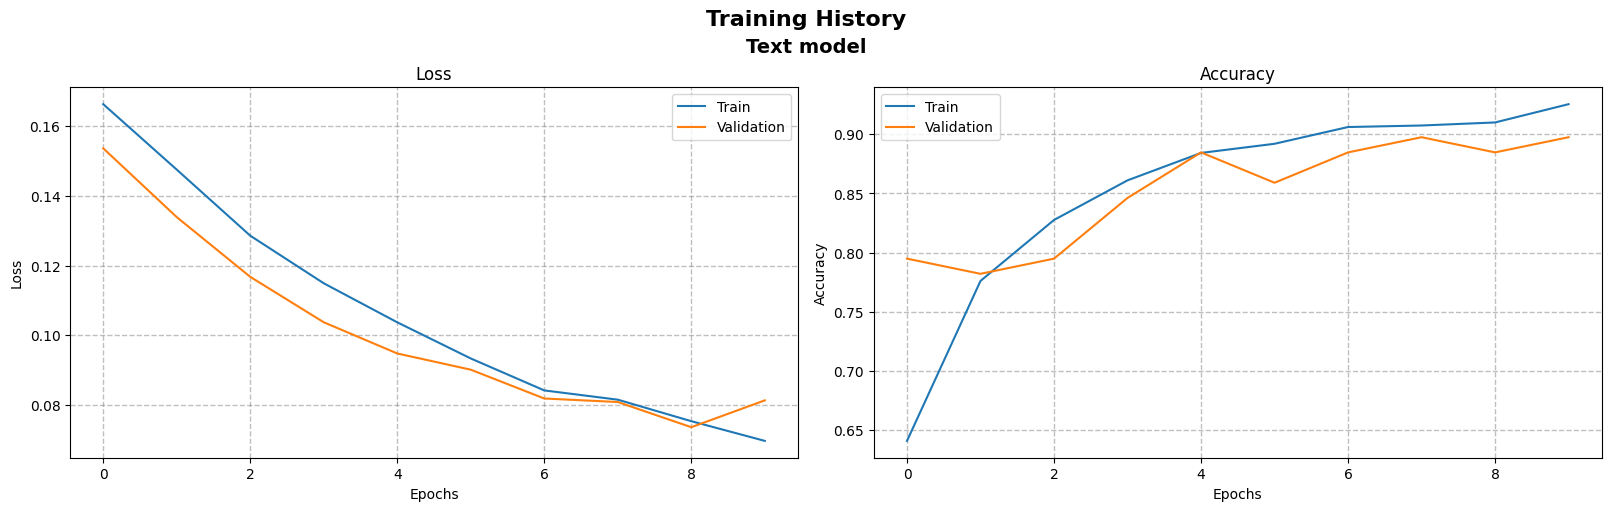

In [ ]:
fig = plt.figure(constrained_layout=True, figsize=(16, 5))
fig.suptitle('Training History', fontsize=16, fontweight='bold')

subfig = fig.subfigures(nrows=1, ncols=1)
subfig.suptitle(f'Text model', fontsize=14, fontweight='bold')
axs = subfig.subplots(nrows=1, ncols=2)
for col, ax in enumerate(axs):
    if col == 0:
        ax.grid(color='gray', linestyle='--', linewidth=1, alpha = 0.5)
        ax.plot(history_train_losses[0], label='Train')
        ax.plot(history_val_losses[0], label='Validation')
        ax.set_title('Loss')
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Loss')
        ax.legend()

    elif col == 1:
        ax.plot(history_train_accuracy[0], label='Train')
        ax.plot(history_val_accuracy[0], label='Validation')
        ax.set_title('Accuracy')
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Accuracy')
        ax.legend()
        ax.grid(color='gray', linestyle='--', linewidth=1, alpha = 0.5)
